# Spatial data Analysis

Looking at the spatial data  i.e. spread of the precense of a person on a particular location for all time periods of a day.

Using PYMC3 Libray . Using the tutorial explained in https://github.com/markdregan/Bayesian-Modelling-in-Python



In [2]:
import pandas as pd
import numpy as np
aruba_dataset_path = '/data/dataDeebul/thesis/dataset/strands/aruba/locations.names'

location_names = {}
count = 0
with open(aruba_dataset_path, 'r') as content_file:
    content = content_file.read()
    content = str.splitlines(content)
for count,location in enumerate(content):
    location_names[count] = location
print(location_names)


aruba_dataset_path = '/data/dataDeebul/thesis/dataset/strands/aruba/locations.min'

dataset = pd.read_csv(aruba_dataset_path, names=['location', 'time'])
dataset['time'] = dataset.index
dataset['time'] = pd.to_timedelta(dataset['time'], unit='m')
dataset['minute'] = (dataset['time']/ np.timedelta64(1, 'm')).astype(int)


#Renaming location number with their names
for key,value in location_names.items():
    dataset.ix[dataset.location ==key, 'location_name'] = value
    
def mod_for_minute(row):
    return row['minute'] % 1440
dataset['sep_minute'] = dataset.apply(mod_for_minute, axis=1)

{0: 'Master bedroom', 1: 'Master bathroom', 2: 'Living room', 3: 'Kitchen', 4: 'Center', 5: 'Corridor', 6: 'Second bedroom', 7: 'Office', 8: 'Second bathroom', 9: 'Outside'}


In [3]:
living_room_data = dataset[dataset['location_name'].isin(['Living room'])]
kitchen_data = dataset[dataset['location_name'].isin(['Kitchen'])]

In [4]:
from IPython.display import Image

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as stats
import scipy.optimize as opt
import statsmodels.api as sm

%matplotlib inline
plt.style.use('bmh')
colors = ['#348ABD', '#A60628', '#7A68A6', '#467821', '#D55E00', 
          '#CC79A7', '#56B4E9', '#009E73', '#F0E442', '#0072B2']

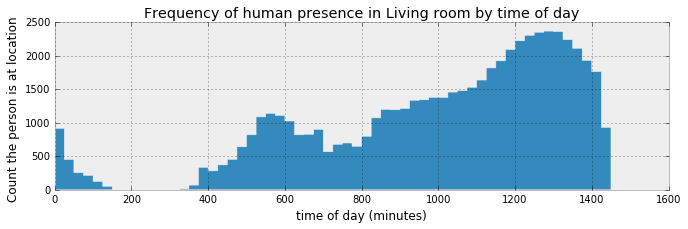

In [5]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of human presence in Living room by time of day')
_ = plt.xlabel('time of day (minutes)')
_ = plt.ylabel('Count the person is at location ')
_ = plt.hist(living_room_data['sep_minute'].values, 
             range=[0, 1500], bins=60, histtype='stepfilled')

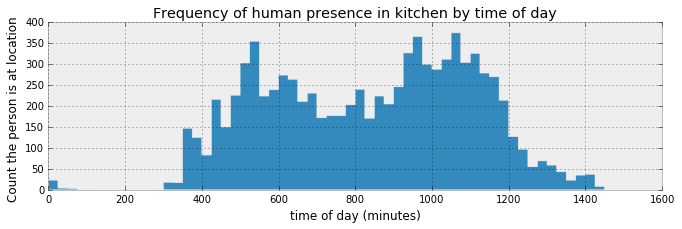

In [21]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of human presence in kitchen by time of day')
_ = plt.xlabel('time of day (minutes)')
_ = plt.ylabel('Count the person is at location ')
_ = plt.hist(kitchen_data['sep_minute'].values, 
             range=[0, 1500], bins=60, histtype='stepfilled')

# Frequentist approach

In [28]:
y_obs = kitchen_data['sep_minute'].values

def poisson_logprob(mu, sign=-1):
    return np.sum(sign*stats.poisson.logpmf(y_obs, mu=mu))

freq_results = opt.minimize_scalar(poisson_logprob)
%time print("The estimated value of mu is: %s" % freq_results['x'])

The estimated value of mu is: 837.602903715
CPU times: user 46 µs, sys: 2 µs, total: 48 µs
Wall time: 55.6 µs


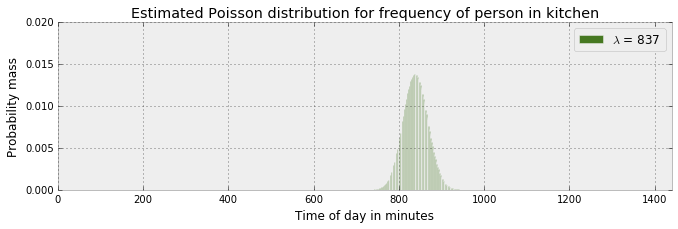

In [31]:
fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(111)
x_lim = 1440
mu = np.int(freq_results['x'])
for i in np.arange(x_lim):
    plt.bar(i, stats.poisson.pmf(mu, i), color=colors[3])
    
_ = ax.set_xlim(0, x_lim)
_ = ax.set_ylim(0, 0.02)
_ = ax.set_xlabel('Time of day in minutes')
_ = ax.set_ylabel('Probability mass')
_ = ax.set_title('Estimated Poisson distribution for frequency of person in kitchen')
_ = plt.legend(['$\lambda$ = %s' % mu])

# Bayesian Analysis

In [34]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=1440)
    likelihood = pm.Poisson('likelihood', mu=mu, observed=kitchen_data['sep_minute'].values)
    
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)


Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 38.0 sec

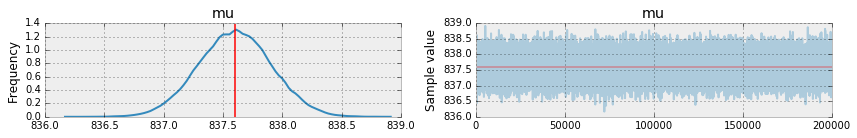

In [35]:
_ = pm.traceplot(trace, varnames=['mu'], lines={'mu': freq_results['x']})

In [36]:
with pm.Model() as model:
    mu = pm.Uniform('mu', lower=0, upper=1440)
    y_est = pm.Poisson('y_est', mu=mu, observed=kitchen_data['sep_minute'].values)
    y_pred = pm.Poisson('y_pred', mu=mu)    
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)



Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 68.7 sec

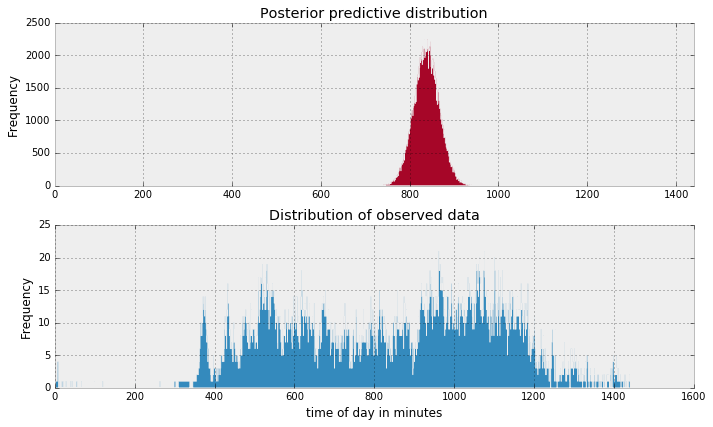

In [37]:
x_lim = 1440
burnin = 50000

y_pred = trace[burnin:].get_values('y_pred')
mu_mean = trace[burnin:].get_values('mu').mean()

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=x_lim, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(kitchen_data['sep_minute'].values, range=[0, x_lim], bins=x_lim, histtype='stepfilled')
_ = plt.xlabel('time of day in minutes')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()


# Negative Binomial Distribution

In [38]:
with pm.Model() as model:
    alpha = pm.Exponential('alpha', lam=.2)
    mu = pm.Uniform('mu', lower=0, upper=1440)
    
    y_pred = pm.NegativeBinomial('y_pred', mu=mu, alpha=alpha)
    y_est = pm.NegativeBinomial('y_est', mu=mu, alpha=alpha, observed=kitchen_data['sep_minute'].values)
    
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(200000, step, start=start, progressbar=True)

Applied log-transform to alpha and added transformed alpha_log to model.
Applied interval-transform to mu and added transformed mu_interval to model.
 [-----------------100%-----------------] 200000 of 200000 complete in 502.8 sec

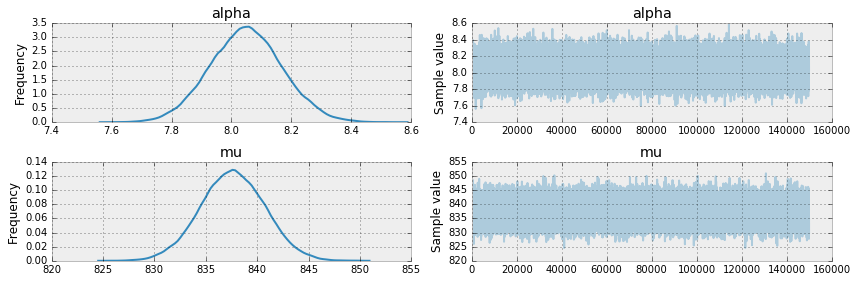

In [39]:
_ = pm.traceplot(trace[burnin:], varnames=['alpha', 'mu'])

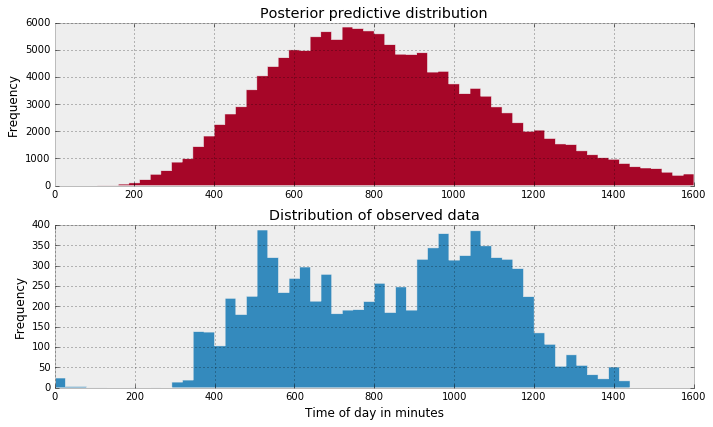

In [44]:
x_lim = 1600
y_pred = trace[burnin:].get_values('y_pred')

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred, range=[0, x_lim], bins=60, histtype='stepfilled', color=colors[1])   
_ = plt.xlim(1, x_lim)
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(kitchen_data['sep_minute'].values, range=[0, x_lim], bins=60, histtype='stepfilled')
_ = plt.xlabel('Time of day in minutes')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

# Circular Distribution 

Using Von mieses distribution to plot the data 


## NOTE : PYMC3 VonMises Distribution find_MAP error
find_MAP doesnt run and without that the algorithm doesnt converge


/home/deebuls/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/deebuls/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


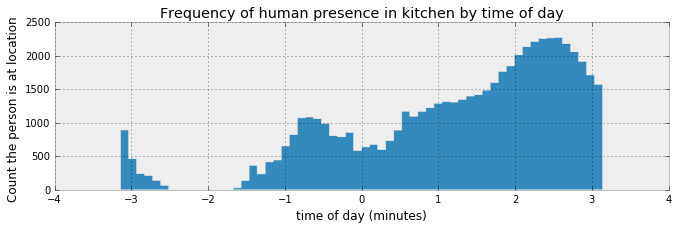

In [6]:
living_room_data.loc[:,'circular_minute'] = ((living_room_data.loc[:,'sep_minute']/1440) * 2 * np.pi ) -   np.pi

fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of human presence in kitchen by time of day')
_ = plt.xlabel('time of day (minutes)')
_ = plt.ylabel('Count the person is at location ')
_ = plt.hist(living_room_data['circular_minute'].values, 
             range=[-np.pi, np.pi], bins=60, histtype='stepfilled')

In [12]:
with pm.Model() as model:
    #alpha = pm.Exponential('alpha', lam=.2)
    alpha = pm.Uniform('alpha', lower=0.0, upper=100.0)
    mu = pm.Uniform('mu', lower=-np.pi, upper=np.pi)
    
    y_pred = pm.VonMises('y_pred', mu=mu, kappa=alpha)
    y_est = pm.VonMises('y_est', mu=mu, kappa=alpha, observed=living_room_data['circular_minute'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(200000, step, start=start, progressbar=True)

Applied interval-transform to alpha and added transformed alpha_interval to model.
Applied interval-transform to mu and added transformed mu_interval to model.
Applied circular-transform to y_pred and added transformed y_pred_circular to model.


UnboundLocalError: local variable 'strace' referenced before assignment

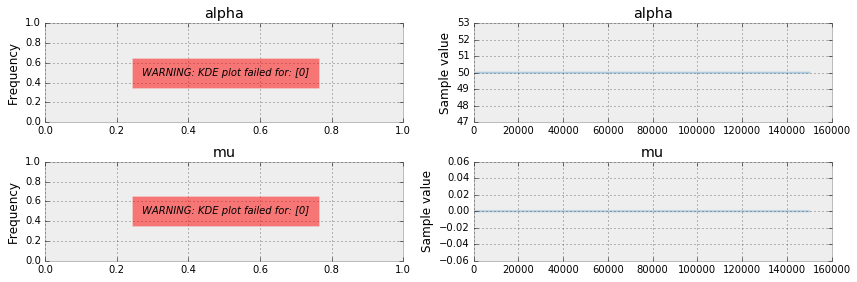

In [95]:
_ = pm.traceplot(trace[burnin:], varnames=['alpha', 'mu'])

# PYMC von mieses


In [1]:
%load_ext autoreload
%autoreload 2
import pymc
import simple_von_mises

model=pymc.MCMC(simple_von_mises)
model.sample(iter=1000, burn=500, thin=2)



{0: 'Master bedroom', 1: 'Master bathroom', 2: 'Living room', 3: 'Kitchen', 4: 'Center', 5: 'Corridor', 6: 'Second bedroom', 7: 'Office', 8: 'Second bathroom', 9: 'Outside'}
 [-----------------100%-----------------] 1000 of 1000 complete in 14.9 sec

/home/deebuls/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:284: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/deebuls/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:461: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


mu 1.7501722096101986
kappa 0.9330386945469735
(8000,)


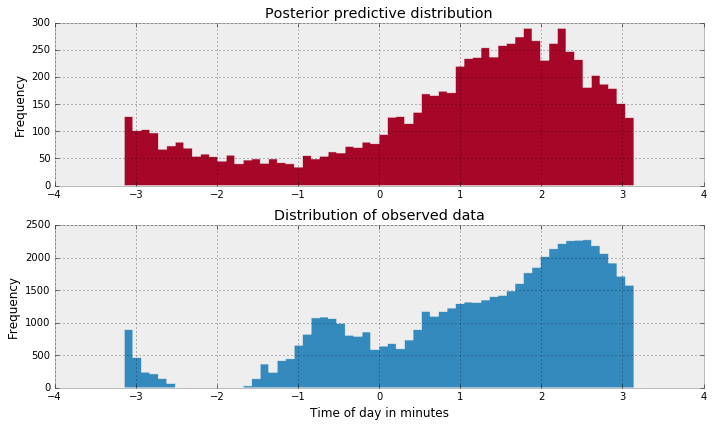

In [8]:
print ('mu',model.mu.value)
print ('kappa',model.kappa.value)


y_pred = pymc.rvon_mises( model.mu.value, model.kappa.value, size=(8000,) )
print (y_pred.shape)

fig = plt.figure(figsize=(10,6))
fig.add_subplot(211)

fig.add_subplot(211)

_ = plt.hist(y_pred,range=[-np.pi, np.pi], bins=60, histtype='stepfilled', color=colors[1])   
_ = plt.ylabel('Frequency')
_ = plt.title('Posterior predictive distribution')

fig.add_subplot(212)

_ = plt.hist(living_room_data['circular_minute'].values, range=[-np.pi, np.pi], bins=60, histtype='stepfilled')
_ = plt.xlabel('Time of day in minutes')
_ = plt.ylabel('Frequency')
_ = plt.title('Distribution of observed data')

plt.tight_layout()

# Mixture Model

Using Non parameteric Bayesian modelling to model mixture of gaussians

from http://austinrochford.com/posts/2016-02-25-density-estimation-dpm.html

Not understood the mathematics need to re read



In [64]:
N = len(kitchen_data['sep_minute'].sample(n=500).values)
K = 5

kitchen_data['minute_std'] = (kitchen_data.sep_minute - kitchen_data.sep_minute.mean() ) / kitchen_data.sep_minute.std()
kitchen_data.head()

/home/deebuls/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,location,time,minute,location_name,sep_minute,minute_std
491,3,08:11:00,491,Kitchen,491,-1.308307
492,3,08:12:00,492,Kitchen,492,-1.304533
493,3,08:13:00,493,Kitchen,493,-1.300758
494,3,08:14:00,494,Kitchen,494,-1.296983
495,3,08:15:00,495,Kitchen,495,-1.293209


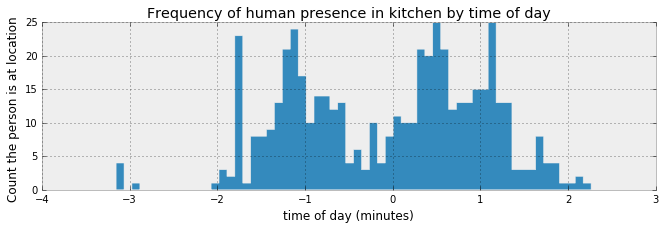

In [65]:
fig = plt.figure(figsize=(11,3))
_ = plt.title('Frequency of human presence in kitchen by time of day')
_ = plt.xlabel('time of day (minutes)')
_ = plt.ylabel('Count the person is at location ')
_ = plt.hist(kitchen_data['minute_std'].sample(n=500).values, bins=60, histtype='stepfilled')

In [66]:
from theano import tensor as T

with pm.Model() as model:
    alpha = pm.Gamma('alpha', 1., 1.)
    beta = pm.Beta('beta', 1., alpha, shape=K)
    w = pm.Deterministic('w', beta * T.concatenate([[1], T.extra_ops.cumprod(1 - beta)[:-1]]))
    component = pm.Categorical('component', w, shape=N)

    tau = pm.Gamma('tau', 1., 1., shape=K)
    lambda_ = pm.Uniform('lambda', 0, 5, shape=K)
    mu = pm.Normal('mu', 0, lambda_ * tau, shape=K)
    obs = pm.Normal('obs', mu[component], lambda_[component] * tau[component],
                    observed=kitchen_data['minute_std'].sample(n=500).values)

Applied log-transform to alpha and added transformed alpha_log to model.
Applied logodds-transform to beta and added transformed beta_logodds to model.
Applied log-transform to tau and added transformed tau_log to model.
Applied interval-transform to lambda and added transformed lambda_interval to model.


In [67]:
with model:
    step1 = pm.Metropolis(vars=[alpha, beta, w, lambda_, tau, mu, obs])
    step2 = pm.ElemwiseCategoricalStep([component], np.arange(K))
    
    trace_ = pm.sample(20000, [step1, step2])

trace = trace_[10000::10]

 [-----------------100%-----------------] 20000 of 20000 complete in 340.1 sec

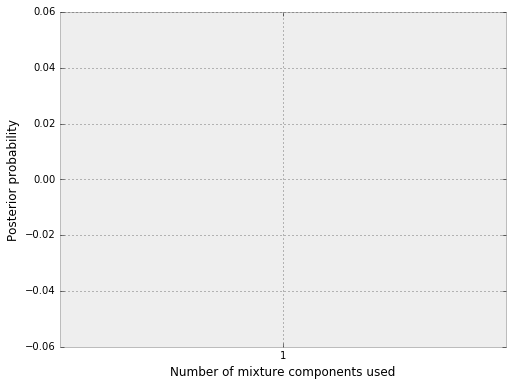

In [68]:

n_components_used = np.apply_along_axis(lambda x: np.unique(x).size, 1, trace['component'])
fig, ax = plt.subplots(figsize=(8, 6))

bins = np.arange(n_components_used.min(), n_components_used.max() + 1)
ax.hist(n_components_used + 1, bins=bins, normed=True, lw=0, alpha=0.75);

ax.set_xticks(bins + 0.5);
ax.set_xticklabels(bins);
ax.set_xlim(bins.min(), bins.max() + 1);
ax.set_xlabel('Number of mixture components used');

ax.set_ylabel('Posterior probability');

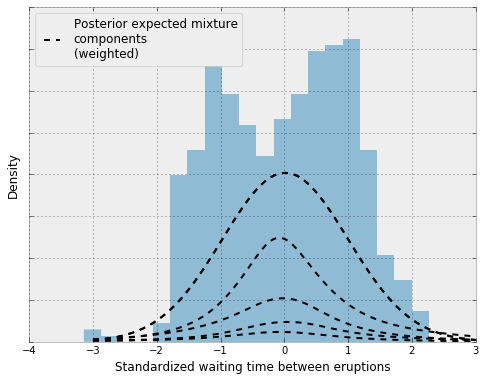

In [69]:
import scipy as sp
fig, ax = plt.subplots(figsize=(8, 6))

n_bins = 20
x_plot = np.linspace(-3, 3, 200)
post_pdf_contribs = sp.stats.norm.pdf(np.atleast_3d(x_plot),
                                      trace['mu'][:, np.newaxis, :],
                                      1. / np.sqrt(trace['lambda'] * trace['tau'])[:, np.newaxis, :])
post_pdfs = (trace['w'][:, np.newaxis, :] * post_pdf_contribs).sum(axis=-1)

post_pdf_low, post_pdf_high = np.percentile(post_pdfs, [2.5, 97.5], axis=0)

ax.hist(kitchen_data.minute_std.sample(n=500).values, bins=n_bins, normed=True, lw=0, alpha=0.5);

ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0)[:, 0],
        '--', c='k', label='Posterior expected mixture\ncomponents\n(weighted)');
ax.plot(x_plot, (trace['w'][:, np.newaxis, :] * post_pdf_contribs).mean(axis=0),
        '--', c='k');

ax.set_xlabel('Standardized waiting time between eruptions');

ax.set_yticklabels([]);
ax.set_ylabel('Density');

ax.legend(loc=2);